In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show

## Loading Data

In [2]:
nm_shp = gpd.read_file("JamaicaNonmangroveLabels.shp")
m_shp = gpd.read_file("JamaicaMangroveLabelsFixed.shp")

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [3]:
src = rasterio.open("JamaicaFeaturesNoSAR.tif") 
mask_src = rasterio.open("JamaicaImageMask.tif") 
m_image, m_transform = mask(src, m_geoms, crop=True) 
nm_image, nm_transform = mask(src, nm_geoms, crop=True)

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop=True)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop=True)

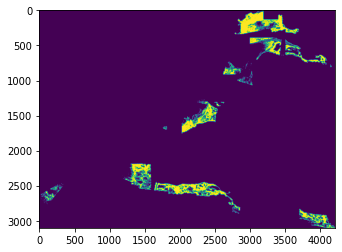

<AxesSubplot:>

In [75]:
show(mmask) 

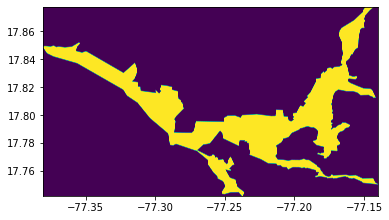

<AxesSubplot:>

In [96]:
show(mask_src) 

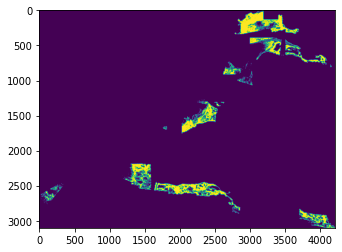

<AxesSubplot:>

In [8]:
show(mmask)

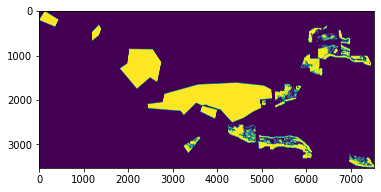

<AxesSubplot:>

In [130]:
show(nmmask)

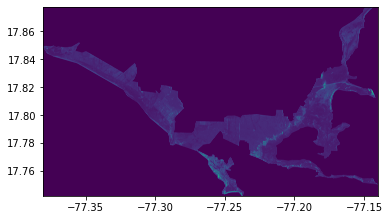

<AxesSubplot:>

In [131]:
show(src)

# Reshaping Data

In [4]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1) 
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)

In [5]:
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]

m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]

In [6]:
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Extremely Randomized Trees Training 

In [89]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
clf = ExtraTreesClassifier(n_jobs=4)
clf.fit(x_train, y_train)

ExtraTreesClassifier(n_jobs=4)

In [90]:
%%time
y_pred = clf.predict(x_test)

CPU times: user 11.3 s, sys: 871 ms, total: 12.2 s
Wall time: 3.22 s


# Model Performance - ERT

In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    459070
         1.0       0.89      0.89      0.89     92074

    accuracy                           0.96    551144
   macro avg       0.93      0.93      0.93    551144
weighted avg       0.96      0.96      0.96    551144



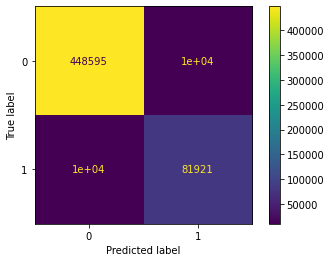

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [106]:
img = reshape_as_image(src.read())
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

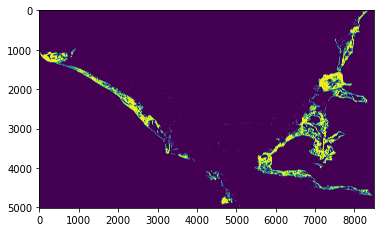

<AxesSubplot:>

In [107]:
output = clf.predict(array)
output_img = output.reshape(img.shape[0], img.shape[1], 1)
show(output_img)

In [108]:
out_meta = src.meta.copy()
out_meta.update({"count": 1})
with rasterio.open('output_supervisedert+dtm.tif', 'w', **out_meta) as dst:
    dst.write(reshape_as_raster(output_img))

# SVM Training

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)

# Model Performance - SVM

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svm_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
img = reshape_as_image(src.read())
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

In [ ]:
output = svm.predict(array)
output_img = output.reshape(img.shape[0], img.shape[1], 1)
show(output_img)

In [ ]:
out_meta = src.meta.copy()
out_meta.update({"count": 1})
with rasterio.open('output_supervisedsvm+dtm.tif', 'w', **out_meta) as dst:
    dst.write(reshape_as_raster(output_img))

# LightGBM Training

In [2]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train)

In [ ]:
params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Multi-class target feature
params['metric']='auc' #metric for multi-class

gbm = lgb.train(params, d_train, 100)
lgb_pred = gbm.predict(x_test)

# Model Performance - LightGBM

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lgb_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, lgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
img = reshape_as_image(src.read())
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

In [ ]:
output = gbm.predict(array)
output_img = output.reshape(img.shape[0], img.shape[1], 1)
show(output_img)

In [ ]:
out_meta = src.meta.copy()
out_meta.update({"count": 1})
with rasterio.open('output_supervisedgbt+dtm.tif', 'w', **out_meta) as dst:
    dst.write(reshape_as_raster(output_img))

# XGBoost Training

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [9]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [10]:
#%%time
xgb_pred = xgb_model.predict(x_test)

In [11]:
#see the prediction
xgb_predictions = [round(value) for value in xgb_pred]
#predictions

# Model Performance - XGBoost

In [36]:
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

Accuracy: 95.93%


In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    459070
         1.0       0.88      0.88      0.88     92074

    accuracy                           0.96    551144
   macro avg       0.93      0.93      0.93    551144
weighted avg       0.96      0.96      0.96    551144



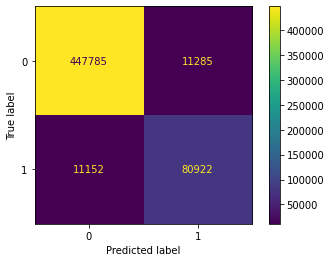

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [103]:
img = reshape_as_image(src.read())
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

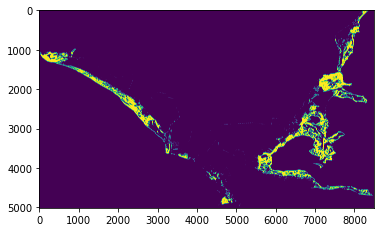

<AxesSubplot:>

In [104]:
output = xgb_model.predict(array)
output_img = output.reshape(img.shape[0], img.shape[1], 1)
show(output_img)

In [105]:
out_meta = src.meta.copy()
out_meta.update({"count": 1})
with rasterio.open('output_supervisedgbt+dtm.tif', 'w', **out_meta) as dst:
    dst.write(reshape_as_raster(output_img))

# Elasticnet Linear model Training

1) **Training with ElasticNet from sklearn.linear_model** <br>
Advantages: make the fastest prediction <br>
Shortcomings: does not make binary prediction, hard to choose a treshold

In [17]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

In [18]:
elastic_net_model = ElasticNet(random_state=0)
elastic_net_model.fit(x_train, y_train)

ElasticNet(random_state=0)

In [19]:
elastic_net_pred = elastic_net_model.predict(x_test)
elastic_net_pred

array([ 0.33802834,  0.20952052, -0.09627154, ...,  0.20920233,
       -0.06105706, -0.00703293], dtype=float32)

2) Alternative: training with **LogisticRegression with a elasticnet penalty**

In [136]:
from sklearn.linear_model import LogisticRegression
elastic_net_model3 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)#combination of l1 and l2
elastic_net_model3.fit(x_train, y_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [137]:
%%time
elastic_net_pred3 = elastic_net_model3.predict(x_test)
elastic_net_pred3

CPU times: user 59.1 ms, sys: 31.8 ms, total: 90.9 ms
Wall time: 32.8 ms


array([0., 0., 0., ..., 0., 0., 0.])

In [147]:
(y_test == elastic_net_pred3).mean()

0.9086391215362954

# Model Performance - Elasticnet Linear model

In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_test, elastic_net_pred3))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    459070
         1.0       0.75      0.68      0.71     92074

    accuracy                           0.91    551144
   macro avg       0.84      0.82      0.83    551144
weighted avg       0.91      0.91      0.91    551144



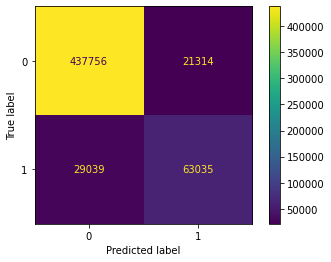

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, elastic_net_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [140]:
img = reshape_as_image(src.read())
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

In [3]:
# output = elastic_net_model3.predict(array)
# output_img = output.reshape(img.shape[0], img.shape[1], 1)
# show(output_img) #need to make changes

## Time and Accuracy Comparison (ERT, XGBoost, and ElasticNet )

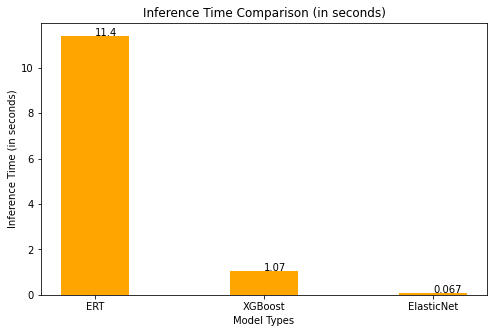

In [73]:
data = {'ERT':11.4, 'XGBoost':1.07, 'ElasticNet':0.067}
courses = list(data.keys())
values = list(data.values())
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])    
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='orange',
        width = 0.4)
plt.title("Inference Time Comparison (in seconds)")
plt.xlabel("Model Types")
plt.ylabel("Inference Time (in seconds)");
addlabels(courses,values);
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

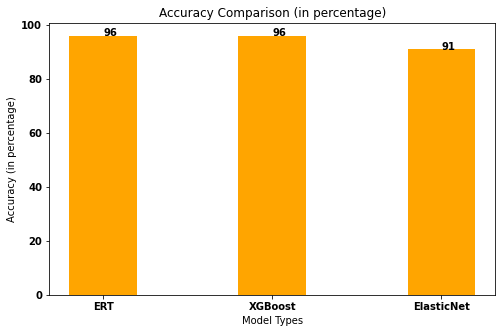

In [54]:
data = {'ERT':96, 'XGBoost':96, 'ElasticNet':91}
courses = list(data.keys())
values = list(data.values())
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='orange',
        width = 0.4)
plt.title("Accuracy Comparison (in percentage)")
plt.xlabel("Model Types")
plt.ylabel("Accuracy (in percentage)")
addlabels(courses,values);